# Cryptanalysis of HB Protocol with Machine Learning
### Content:
1. [Introduction](#introduction)<br> 
2. [Imports](#imports)<br>
3. [LPN Oracle](#define-and-use-lpn-oracle-we-collect-data-from-as)<br>
4. [Calculating threshold and Hamming weight](#calculating-threshold-and-hamming-weight)<br>  
5. [Decision tree](#decision-tree)<br>
6. [Random forest](#random-forest)<br>
7. [Logistic regression and Bernoulli Naive-Bayes](#on-logitstic-regression-and-bernoulli-naive-bayes)<br>
8. [Neural networks](#neural-networks)<br>
9. [References](#references)</br>

### Introduction 
- Solving Learning Parity with Noise problem, later reffered as LPN, arises when trying to break HB protocol, a lightweight cryptographic protocol. <br>
- Where is HB protocol used? Mostly in card readers in hotel, how does it work? <br>
- We have reader(R) and tag(T), that's our RFID chip in a hotel card. If T communicated it's secret key in clear, adversary could simply sniff traffic and obtain the secret key.
- We couldn't use our usual encryption algorithms like AES in RFID chips, since it has low computational power hence the low price.

<b> => HB Protocol</b><br> 
- Scheme goes like this: R is repeatedly challenging T to compute something, that something is vector a, the challenge. Now T responds back with scalar product $ b = \langle a,s \rangle$ where s is secret key T owns, this is repeated a lot times. <br> 
- for example: $ \langle (1,0,0,0),(1,0,1,0) \rangle = 1\cdot1 + 0\cdot0 + 0\cdot1 + 0\cdot0 = 0+0+1+0 = 1$  <br>
- "+" here is actually $\oplus$ (calculating in $GF(2)$ or $\mathbb{F}_2)$<br>
<b>...still insecure</b>
- $\langle a_i,s \rangle = b_i \iff As=b ,\forall i$, we can solve this easily.

- for example: 
$
\begin{bmatrix} 
    1&0&1&1 \\
    0&1&1&1 \\
    0&0&1&0 \\
    0&0&0&1
\end{bmatrix} 
\quad
\begin{bmatrix}
    s_1 \\
    s_2 \\
    s_3 \\
    s4
\end{bmatrix}
=\begin{bmatrix}
    0 \\ 
    1 \\ 
    1 \\ 
    0
\end{bmatrix}
$ 

$
\begin{cases}
s_1 \oplus s_3 \oplus s_4 = 0 \\
s_2 \oplus s_3 \oplus s_4 = 1 \\
s_3 = 1 \\
s_4 = 0
\end{cases}
$

$ s_1 \oplus 1 \oplus 0 = 0 => s_1 \oplus 1 = 0 => s_1 = 0 \oplus 1 = 1$
<br>
$ s_2 \oplus 1 \oplus 0 = 1 => s_2 \oplus 1 = 1 => s_2 = 1 \oplus 1 = 0$

... so the key is 1 0 1 0

<b> LPN </b>
- We tweak this algorithm by adding error term $e$ to our scalar product , so T sends $\langle a,s \rangle + e$ back to R , with probability $1-p$ it sends $\langle a,s \rangle $ and with probability $p$ it flips bit from 0 to 1 (1 to 0)
- Now adversary has to solve system of equations $A \approx b$ , for large enough length of secrety key, this is infeasible 

<b> Using machine learning</b>
- We are going to treat each row $a_i$ of matrix A as sample and $b_i = \langle a_i,s \rangle + e_i $ from vector b as label 
- If we throw in vector a = (0,1,0,0) (basis vector), we would recieve a guess for second bit of s (corresponding bit in a key)<br>
$b = \langle (1,0,0,0),s \rangle = 0\cdot s_1 + 1\cdot s_2 + 0 \cdot s_3 + 0 \cdot s_4 = s_2$
- (that's why i'll be using  np.eye(n) to predict key)

<b>Algorithms/techniques</b>
- Decision tree, Random forest, Logistic regression, Bernuolli Naive-Bayes, Neural networks


### Imports

In [2]:
import numpy as np
import pickle
import pandas as pd 
import tensorflow as tf 

from termcolor import colored
from matplotlib import pyplot as plt  
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier

### Define and use LPN Oracle we collect data from as:
- It is very common in cryptography to use Oracle to get samples so that's what we'll do here.
- Code for LPNOracle taken from [3].

In [2]:
class LPNOracle:
    def __init__(self, secret, error_rate):
        self.secret = secret
        self.dimension = len(secret)
        self.error_rate = error_rate

    def sample(self, n_amount):
        # Create random matrix.
        A = np.random.randint(0, 2, size=(n_amount, self.dimension))
        # Add Bernoulli errors.
        e = np.random.binomial(1, self.error_rate, n_amount)
        # Compute the labels.
        b = np.mod(A @ self.secret + e, 2)
        return A, b

In [3]:
def set_key_get_oracle(p,n):
    s = np.random.randint(0,2,n)
    lpn = LPNOracle(s,p)
    
    return lpn,s 

### Calculating threshold and Hamming weight
- here we calculate threshold with formula given in [1, page23] <br>
$ t:= m\tau + \sqrt{km}$ <br> 
- where: <br>
    1. m - number of samples 
    2. k - dimension of problem, $k\isin \N$ 
    3. $\tau$ - error rate $\tau \isin [0,\frac{1}{2})$

In [4]:
def calculate_threshold(k,tau,m):
    return m*tau + np.sqrt(k*m)

How do we intrepret this?<br> 
- if $wt(As'+b)\le t$ we accept s' as correct key, otherwise we reject it
- where:
    1. $t$ is threshold we calculated before  
    2. $s'$ is our prediction for key
    3. $(A,b)\leftarrow \mathcal{LPN}^{m}_{k,\tau}$ sampled from LPN oracle
    4. $wt(\cdot)$ is Hamming weight of vector, or number of ones in it, in code: 
    

In [5]:
def calculate_hw(A,b,s_prime,t):
    return np.mod(A@s_prime+b,2).sum() <= t 

In [6]:
def check_prediction(A,b,s_prime,samples,p,n,s):
    t = calculate_threshold(n,p,samples)

    percentage = np.mean(s_prime==s)*100

    if calculate_hw(A,b,s_prime,t):
        print(colored('Success','green'))
    else:
        print(colored('Failed','red'))
    print(s_prime, s)
    print(str(percentage)+"%")

    return percentage

### Decision tree

In [7]:
def train_dt(A,b,n):
    dt = DecisionTreeClassifier(criterion='entropy')


    dt.fit(A,b)

    s_prime = dt.predict(np.eye(n))
 
    return s_prime

In [224]:
samples = 100000
p = 0.125 
n = 15 

lpn,s = set_key_get_oracle(p,n)

A,b = lpn.sample(samples)

s_prime = train_dt(A,b,n)

check_prediction(A,b,s_prime,samples,p,n,s)

Success
[0 0 0 0 0 1 1 0 1 1 1 0 1 0 0] [0 0 0 0 0 1 1 0 1 1 1 0 1 0 0]
100.0%


In [139]:
def load_data_frames():
    df = pd.read_csv('data/data.csv')
    grouped = df.groupby(df.samples)
    dfs = [] 
    samples = [10,10000,100000,1000000,10000000]
    for s in samples: 
        dfs.append(grouped.get_group(s))
    return dfs 

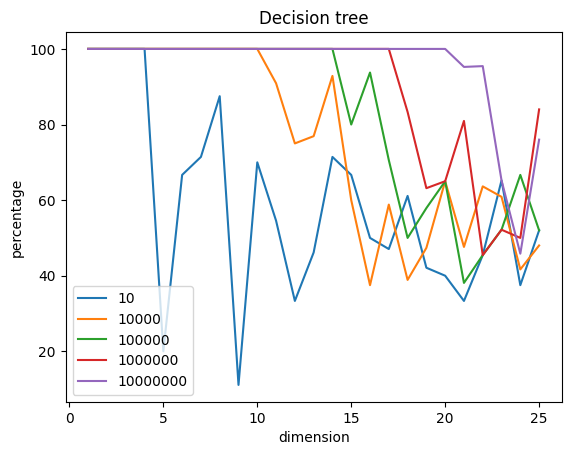

In [140]:
def plot_data(classifier): 
    dfs = load_data_frames()
    ax = dfs[0].plot(x='dimension',y='percentage',ylabel='percentage',title=classifier)
    for df in dfs[1:]: 
        df.plot(ax=ax,x='dimension',y='percentage',ylabel='percentage',title=classifier)
    ax.legend([10,10000,100000,1000000,10000000])

plot_data('Decision tree')

<b>On statistics and samples</b>
- In my plotted data i capped my samples to 10 million and dimension to 25, reason is hardware limitation of my computer(whole tree has to be loaded into memory).
- Another reason is optimism in obtaining so much samples, namely there are smarter attacks that require only $O(n)$ (where $n$ is dimension of our problem) samples described in [2].

In [5]:
n = 23
p = 0.125 
samples = 10000000
filename = 'decision_tree_'+str(n)+'_'+str(samples)+'.joblib'


with open(filename,'rb') as file: 
    dt = pickle.load(file)
    
loaded = np.load('sampled_data.npz')

A = loaded['A']
b = loaded['b']
s = loaded['s']

s_prime = dt.predict(np.eye(n))

check_prediction(A,b,s_prime,samples,p,n,s)

Failed
[0 0 1 0 0 1 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0] [0 0 1 0 1 1 1 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0]
91.30434782608695%


91.30434782608695

### Random forest 
- I liked the idea of ensembles and how i could use them to boost my learning, but when i've written my code i noticed it performed worse in comparison to single Decision Tree, so i figured it could be due to random forest algorithm selecting random subset of features as well as random sampling(althought not as much) and failing to learn. 

In [49]:
p = 0.125
n = 15
s = np.random.randint(0,2,n)
lpn=LPNOracle(s,p)

rf = RandomForestClassifier(criterion='entropy')

samples = 100000
A,b = lpn.sample(samples)

rf.fit(A,b)

s_prime = rf.predict(np.eye(n))

check_prediction(A,b,s_prime,samples,p,n,s)

Fail
[0 0 1 0 0 0 0 0 1 0 1 0 0 1 0] [0 0 1 0 0 1 0 0 1 0 1 0 1 1 0]
86.66666666666667%


<b> idea</b>
- So, i didn't really want to give up on this idea, i liked the voting factor in random forest, so i decided to simulate it somehow...
- My first approach was to divide my data into different subsets, then to train it on that data and vote on bits of my key, it didn't really work, it would be on par with one decision tree or sometimes worse, precision-wise...
- but then i tried picking data from my vectors A,b given from LPNOracle at random, but difference in bagging is that it takes more data than the number of samples i am given, it is less performant approach, but it outperformes single decision tree in terms of precision
- i use 3 * number of samples and 6*n trees , i tested and came to this conclusion

In [31]:
def my_forest(A,b,samples,n,tree_num=n*6):
    d = tree_num
    A,b = lpn.sample(samples)
    s_primes = np.empty((d,n)) 
  
    for i in range(0,d):
        dt = DecisionTreeClassifier(criterion='entropy')
        indexes = np.random.randint(A.shape[0],size=3*samples)
        dt.fit(A[indexes],b[indexes])
        s_primes[i] = dt.predict(np.eye(n)) 
        

    prob = np.count_nonzero(s_primes==0,axis=0)/d
    s_prime= prob<=0.5
    s_prime = s_prime.astype(int) 

    return s_prime 

In [229]:
samples = 75000
p = 0.125 
n = 15 
lpn,s=set_key_get_oracle(p,n)
A,b = lpn.sample(samples)

s_prime = my_forest(A,b,samples,n)

print(colored('My forest algorithm','blue'))
check_prediction(A,b,s_prime,samples,p,n,s)

s_prime = train_dt(A,b,n)

print(colored('Single decision tree','blue'))
check_prediction(A,b,s_prime,samples,p,n,s)

My forest algorithm
Success
[0 1 1 1 0 1 0 0 0 1 0 0 0 1 1] [0 1 1 1 0 1 0 0 0 1 0 0 0 1 1]
100.0%
Single decision tree
Fail
[1 1 0 1 1 1 0 0 0 1 0 0 0 1 1] [0 1 1 1 0 1 0 0 0 1 0 0 0 1 1]
80.0%


### On Logitstic regression and Bernoulli Naive-Bayes 
- i was expecting Bernoulli Naive-Bayes to be more performant, but in general training both of these algorithms, they have very low precision, works on keys that hold very bad statistical properties, for instance they only learned on keys that are basis vector( [1 0 0 0 0]), nevertheless let me show...

In [36]:
samples = 1000000
p = 0.125 
n = 15 
lpn,s = set_key_get_oracle(p,n)
A,b = lpn.sample(samples)

bnb = BernoulliNB()
bnb.fit(A,b)
s_prime = bnb.predict(np.eye(n))

check_prediction(A,b,s_prime,samples,p,n,s)

Failed
[1 0 1 1 1 0 0 1 1 1 1 0 1 1 1] [0 1 1 0 0 1 1 0 0 1 1 1 1 0 1]
33.33333333333333%


33.33333333333333

In [49]:
samples = 100000
p = 0.125 
n = 15 
lpn,s = set_key_get_oracle(p,n)
A,b = lpn.sample(samples)

clf = LogisticRegression()
clf.fit(A,b)
s_prime = clf.predict(np.eye(n))

check_prediction(A,b,s_prime,samples,p,n,s)

Failed
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0] [0 0 1 1 1 1 0 1 0 1 1 0 0 1 1]
46.666666666666664%


46.666666666666664

### Neural networks

- What i've noticed about Neural Networks is that it converges quickly to say 0.8 accuracy, it outperforms decision tree and it doesn't need that much data at all. Our model with n=15 and needing only 7500 samples, meanwhile decision tree needs 100000.
- Best results was learning n=29 with 4 million samples, followed by n=30 with 5 million samples and accuracy of 96%,it needs ~10 times less samples than Decision tree 
- Another observation is that >=0.8 accuracy is good enough to predict the correct key.
- I used rather simple Neural Network to learn, down below is training i used (tweaks in epochs and batch_size when traning bigger dimension problems), but on simpler version so it can be tested fast 

In [239]:
n = 19
p = 0.125
samples = 50000

lpn,s = set_key_get_oracle(p,n)
A,b = lpn.sample(samples)

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Dense(64,input_shape=(n,),activation='relu'))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.fit(A,b,epochs=50,batch_size=64)

probs = model.predict(np.eye(n))

threshold = 0.5
s_prime = [1 if p >= threshold else 0 for p in probs]

check_prediction(A,b,np.asarray(s_prime),samples,p,n,s)

Epoch 1/50
782/782 [==============================] - 2s 2ms/step - loss: 0.6955 - accuracy: 0.5002
Epoch 2/50
782/782 [==============================] - 1s 2ms/step - loss: 0.6941 - accuracy: 0.5006
Epoch 3/50
782/782 [==============================] - 1s 2ms/step - loss: 0.6933 - accuracy: 0.5097
Epoch 4/50
782/782 [==============================] - 1s 2ms/step - loss: 0.6928 - accuracy: 0.5123
Epoch 5/50
782/782 [==============================] - 1s 2ms/step - loss: 0.6918 - accuracy: 0.5217
Epoch 6/50
782/782 [==============================] - 1s 2ms/step - loss: 0.6917 - accuracy: 0.5214
Epoch 7/50
782/782 [==============================] - 1s 2ms/step - loss: 0.6912 - accuracy: 0.5251
Epoch 8/50
782/782 [==============================] - 1s 2ms/step - loss: 0.6907 - accuracy: 0.5284
Epoch 9/50
782/782 [==============================] - 1s 2ms/step - loss: 0.6904 - accuracy: 0.5298
Epoch 10/50
782/782 [==============================] - 1s 2ms/step - loss: 0.6884 - accuracy: 0.5403

In [9]:
n = 29 
model = tf.keras.models.load_model('models/nn_29_4000000.h5')
probs = model.predict(np.eye(n))

threshold = 0.5 
s_prime = [1 if p>= threshold else 0 for p in probs]
print(colored('Prediction:','blue')+str(np.asarray(s_prime)))

secret_key = np.load('models/secret_key.npz')
print(colored('Real key:','green')+str(secret_key['s']))

1/1 [==============================] - 0s 88ms/step
Prediction:[1 0 0 0 1 1 1 1 0 0 0 1 0 1 0 0 1 1 1 1 1 0 1 0 1 0 0 1 1]
Real key:[1 0 0 0 1 1 1 1 0 0 0 1 0 1 0 0 1 1 1 1 1 0 1 0 1 0 0 1 1]


<b> Comparison between Decision tree and Neural network</b>
- Data will show highest achieved accuracy for given key dimension

<b> Neural network </b> 
| n | Samples | Accuracy | 
|---|---------|----------|
|15 | 7500    | 100%     |
|16 | 10000   | 100%     |
|17 | 15000   | 100%     |
|18 | 20000   | 100%     |
|19 | 50000   | 100%     |
|20 | 75000   | 100%     |
|21 | 100000  | 100%     |
|22 | 125000  | 100%     |
|23 | 150000  | 100%     |
|24 | 175000  | 100%     |
|25 | 200000  | 100%     |
|26 | 250000  | 100%     |
|27 | 500000  | 100%     |
|28 | 1000000 | 100%     |
|29 | 4000000 | 100%     |
|30 | 5000000 | 96%     |

<b> Decision tree </b> 
| n | Samples | Accuracy | 
|---|---------|----------|
|15 | 100000  | 100%     |
|16 | 100000  | 93.75%   |
|17 | 1000000 | 100%     |
|18 | 1000000 | 83.3%    |
|19 | 10000000| 100%     |
|20 | 10000000| 100%     |
|21 | 10000000| 95.24%   |
|22 | 10000000| 95.45%   |
|23 | 10000000| 65.22%   |
|24 | 10000000| 45.83%   |
|25 | 10000000| 76%      |
|26 | NA      | NA       |
|27 | NA      | NA       |
|28 | NA      | NA       |
|29 | NA      | NA       |
|30 | NA      | NA       |

### References
- [1] R. Kübler, Time-Memory Trade-Offs for the Learning Parity with Noise Problem (2018), Dissertation (Ruhr University Bochum) (https://hss-opus.ub.ruhr-uni-bochum.de/opus4/frontdoor/deliver/index/docId/5940/file/diss.pdf)<br> 
- [2] Gołębiewski, Z., Majcher, K., Zagórski, F., Zawada, M. (2011). Practical Attacks on HB and HB+ Protocols. In: Ardagna, C.A., Zhou, J. (eds) Information Security Theory and Practice. Security and Privacy of Mobile Devices in Wireless Communication. WISTP 2011 (https://link.springer.com/chapter/10.1007/978-3-642-21040-2_17) <br>
- [3] Where Machine Learning meets Cryptography (https://towardsdatascience.com/where-machine-learning-meets-cryptography-b4a23ef54c9e)